In [2]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%autoreload 2

from copy import deepcopy
import itertools
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib import colors
from matplotlib.colors import Normalize
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
from sklearn import manifold
import sys
import torch
from tqdm.auto import tqdm

plt.style.use('/om2/user/eisenaj/code/ChaoticConsciousness/sci_style.py')

sys.path.append('../..')
from data_utils import get_data_class, load_session_data, load_window_from_chunks, combine_grid_results

sys.path.append('/om2/user/eisenaj/code/DeLASE')
from delase import *
from dmd import embed_signal_torch
from utils import numpy_torch_conversion

In [4]:
def get_section(t, section_times):
    for section, bounds in section_times.items():
        if t >= bounds[0] and t < bounds[1]:
            return section

# Load Data

In [5]:
# session = 'MrJones-Anesthesia-20160109-01'
session = 'MrJones-Anesthesia-20160210-01'
start_times = np.int0(np.hstack([np.linspace(1600, 2300, 15), np.linspace(2700, 3250, 12), np.linspace(3500, 4200, 15), np.linspace(5000, 5700, 15), np.linspace(6500, 7000, 11)]))
# session = 'Mary-Anesthesia-20160912-02'
results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/session_results'

In [6]:
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp_schema, session_info, spike_times, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['trialInfo'], session_vars['unitInfo']

In [7]:
eyes_open = session_info['eyesOpen'][-1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

In [8]:
# section_times = dict( 
#         wake=(0, session_info['drugStart'][0]),
#         induction=(session_info['drugStart'][0], eyes_close),
#         anesthesia=(eyes_close, session_info['drugEnd'][1]),
#         recovery=(session_info['drugEnd'][1], T*dt)
# )

section_times = dict( 
        wake=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        anesthesia=(eyes_close, session_info['drugStart'][1]),
        late_anesthesia=(session_info['drugStart'][1], session_info['drugEnd'][1]),
        recovery=(session_info['drugEnd'][1], T*dt)
)

sections = list(section_times.keys())

In [9]:
tone_on = trial_info['cpt_toneOn'][~np.isnan(trial_info['cpt_toneOn'])]
tone_off = trial_info['cpt_toneOff'][~np.isnan(trial_info['cpt_toneOff'])]
puff_on = trial_info['cpt_puffOn'][~np.isnan(trial_info['cpt_puffOn'])]

In [10]:
section_times

{'wake': (0, 2656.2257333333337),
 'induction': (2656.2257333333337, 3322.5017000000003),
 'anesthesia': (3322.5017000000003, 4456.225733333334),
 'late_anesthesia': (4456.225733333334, 6256.225733333334),
 'recovery': (6256.225733333334, 9753.123)}

## Check delay embedding dim

In [482]:
dir_ = f"/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat/propofolPuffTone/{session}_lfp_chunked_20s"
directory = pd.read_pickle(os.path.join(dir_, "directory"))

In [484]:
from scipy.signal import argrelextrema
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from nolitsa import delay

In [609]:
# t_ = 2000
t_ = 5000
window = 30
lfp_vals = load_window_from_chunks(t_, t_+ window, directory)

In [610]:
pca = PCA(n_components=6)
signal = pca.fit_transform(lfp_vals)

In [591]:
def compute_delayed_mi(signal, num_lags=500, verbose=False):
    delayed_mi = np.zeros(num_lags + 1)
    T = signal.shape[0]
    for t in tqdm(range(num_lags + 1), disable=verbose < 2):
        for i in range(signal.shape[1]):
            delayed_mi[t] += delay.mi(signal[:T-t, i], signal[t:, i], bins=64)
        delayed_mi[t] /= signal.shape[1]
    
    return delayed_mi

In [592]:
delayed_mi = compute_delayed_mi(signal)

In [593]:
local_min_inds = argrelextrema(delayed_mi, np.less)[0]
delay_tau = local_min_inds[0]

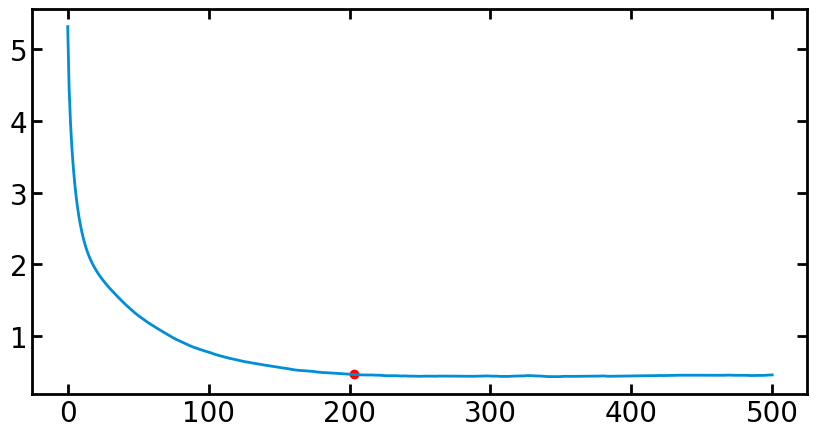

In [594]:
plt.plot(delayed_mi)
plt.scatter(local_min_inds[0], delayed_mi[local_min_inds[0]], c='r')

In [611]:
delay_tau = 100

In [612]:
from dmd import embed_signal_torch
delay_p = 10
signal = embed_signal_torch(signal, delay_p, delay_tau)

In [613]:
signal.shape

torch.Size([29100, 60])

In [614]:
subsample = 3
signal = signal[np.arange(0, signal.shape[0], subsample)]

In [615]:
signal.shape

torch.Size([9700, 60])

In [616]:

ltsa_n_components = 3
n_neighbors_pct = 2.5
n_neighbors = int((n_neighbors_pct/100) * signal.shape[0])

In [617]:
embed = LocallyLinearEmbedding(method="ltsa", n_components=ltsa_n_components, n_neighbors=n_neighbors)
embedded_signal = embed.fit_transform(signal)

In [618]:
embedded_signal.shape

(9700, 3)

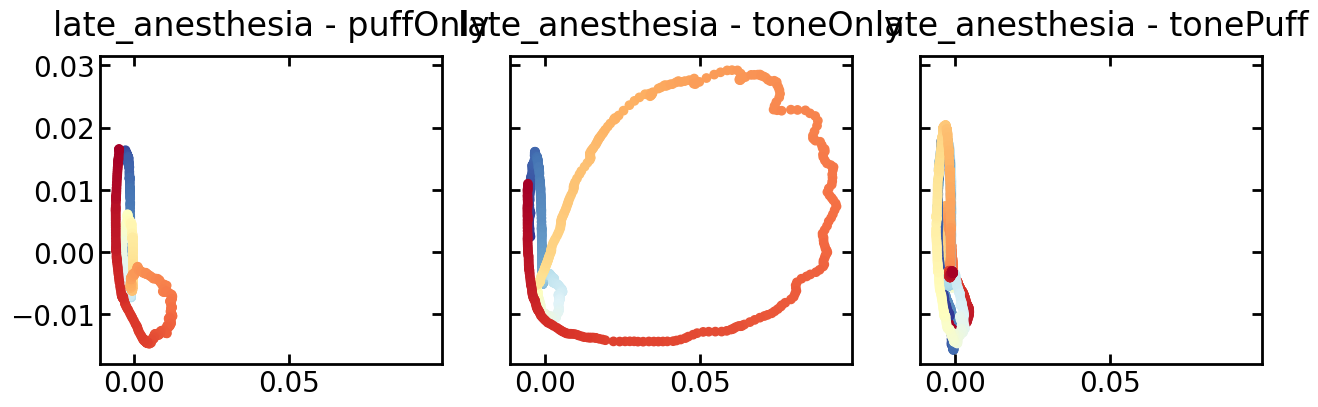

In [619]:
fig, axs = plt.subplots(len([t_]), 3, sharey='row', sharex='row', figsize=(15, 4*len([t_])))

cmap = plt.cm.get_cmap('RdYlBu_r')
color_list = cmap(np.linspace(0, 1, int(response_length/(dt*subsample))))

for j, t in enumerate([t_]):
    section = get_section(t, section_times)
    trial_indices = (trial_info['cpt_refTime'] >= t) & (trial_info['cpt_refTime'] < t + window)
    ref_times = trial_info['cpt_refTime'][trial_indices]
    trial_types = trial_info['cpt_trialType'][trial_indices]

    # axs = subfigs[t_num].subplots(1, 3, sharey='row')
    # axs = subfigs[t_num].subplots(1, 3)

    for i, trial_type in enumerate(np.unique(trial_types)):
        trial_locs = np.int0((ref_times[trial_types == trial_type] - t)*(1/dt)/subsample)
        ax = axs[i]
        for loc in trial_locs:
            loc_emb_signal = embedded_signal[loc:loc+int(response_length/(dt*subsample)), :]
            if loc_emb_signal.shape[0] != int(response_length/(dt*subsample)):
                continue
            # print(loc + int(response_length/(dt*subsample)))
            
            ax.scatter(loc_emb_signal[:, 0], loc_emb_signal[:, 1], c=color_list)
            ax.set_title(f"{section} - {trial_type}")

plt.show()

In [587]:
embed.reconstruction_error_

2.170892850037543

In [509]:
embed.reconstruction_error_

10.015720220837098

# Load Results

In [11]:
results_dir = f"/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/ltsa_dim_reduction_multirun/{session}"

In [12]:
os.listdir(results_dir)

['pca_dims=6_delay_p=10_delay_tau=100_standardize=True_subsample=3_ltsa_n_components=3_n_neighbors_pct=2.5_window=30',
 'pca_dims=6_delay_p=128_delay_tau=5_standardize=True_subsample=3_ltsa_n_components=3_n_neighbors_pct=2.5_window=30',
 'pca_dims=12_delay_p=10_delay_tau=200_standardize=True_subsample=3_ltsa_n_components=3_n_neighbors_pct=2.5_window=30',
 'pca_dims=12_delay_p=32_delay_tau=200_standardize=True_subsample=3_ltsa_n_components=3_n_neighbors_pct=2.5_window=30',
 'pca_dims=6_delay_p=32_delay_tau=200_standardize=True_subsample=3_ltsa_n_components=3_n_neighbors_pct=2.5_window=30',
 'pca_dims=6_delay_p=64_delay_tau=10_standardize=True_subsample=3_ltsa_n_components=3_n_neighbors_pct=2.5_window=30',
 'pca_dims=12_delay_p=10_delay_tau=50_standardize=True_subsample=3_ltsa_n_components=3_n_neighbors_pct=2.5_window=30',
 'pca_dims=12_delay_p=10_delay_tau=75_standardize=True_subsample=3_ltsa_n_components=3_n_neighbors_pct=2.5_window=30',
 'pca_dims=6_delay_p=10_delay_tau=200_standardiz

In [50]:
pca_dims = 12
delay_p = 10
delay_tau = 50

# pca_dims = 12
# delay_p = 32
# delay_tau = 20

standardize = True
subsample = 3
ltsa_n_components = 3
n_neighbors_pct = 2.5
window = 30
run_dir = f"pca_dims={pca_dims}_delay_p={delay_p}_delay_tau={delay_tau}_standardize={standardize}_subsample={subsample}_ltsa_n_components={ltsa_n_components}_n_neighbors_pct={n_neighbors_pct}_window={window}"

In [51]:
all_embedded_signals = {}
start_times = np.sort([float('.'.join(t.split('.')[:2])) for t in os.listdir(os.path.join(results_dir, run_dir))])
for t in start_times:
    all_embedded_signals[t] = pd.read_pickle(os.path.join(results_dir, run_dir, f"{t:.3f}.pkl"))

In [52]:
# tone_times = {}
# puff_times = {}
# for t in time_vals:
#     tone_times[t] = tone_on[(tone_on >= time_vals[0]) & (tone_on <= time_vals[0] + 30)]
#     puff_times[t] = puff_on[(puff_on >= time_vals[0]) & (puff_on <= time_vals[0] + 30)]

# Separating By Trial Type

In [662]:
trial_info.keys()

dict_keys(['Properties', 'badTimingTrials', 'badTrials', 'cpt_puffOff', 'cpt_puffOn', 'cpt_refTime', 'cpt_toneOff', 'cpt_toneOn', 'cpt_trialType', 'drugPhase', 'drugPhaseTime', 'refTime', 'sac_correct', 'sac_delayEnd', 'sac_delayLength', 'sac_fixationTime', 'sac_fixptOn', 'sac_outcome', 'sac_sampleLoc', 'sac_sampleOff', 'sac_sampleOn', 'session', 'task', 'trial', 'trialStart'])

In [663]:
start_times

array([1600., 1650., 1700., 1750., 1800., 1850., 1900., 1950., 2000.,
       2050., 2100., 2150., 2200., 2250., 2300., 2700., 2750., 2800.,
       2850., 2900., 2950., 3000., 3050., 3100., 3150., 3200., 3250.,
       3500., 3550., 3600., 3650., 3700., 3750., 3800., 3850., 3900.,
       3950., 4000., 4050., 4100., 4150., 4200., 5000., 5050., 5100.,
       5150., 5200., 5250., 5300., 5350., 5400., 5450., 5500., 5550.,
       5600., 5650., 5700., 6500., 6550., 6600., 6650., 6700., 6750.,
       6800., 6850., 6900., 6950., 7000.])

In [664]:
time_vals = [2000, 4000]

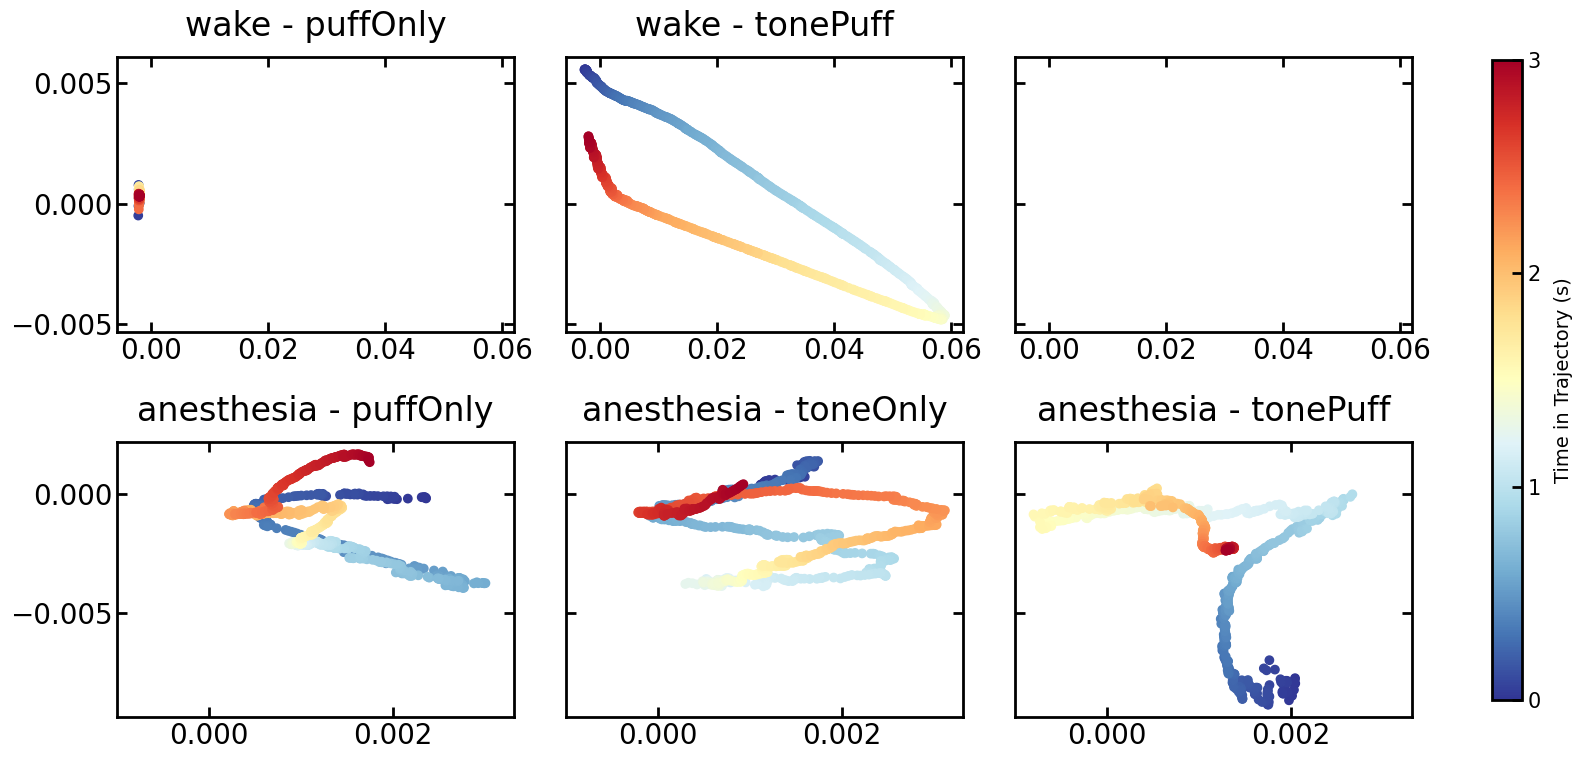

In [665]:
response_length = 3 # s

# fig = plt.figure(layout='constrained', figsize=(15, 8))
# subfigs = fig.subfigures(2, 1, wspace=0.07)

fig, axs = plt.subplots(len(time_vals), 3, sharey='row', sharex='row', figsize=(15, 4*len(time_vals)))

cmap = plt.cm.get_cmap('RdYlBu_r')
color_list = cmap(np.linspace(0, 1, int(response_length/(dt*subsample))))

for j, t in enumerate(time_vals):
    section = get_section(t, section_times)
    trial_indices = (trial_info['cpt_refTime'] >= t) & (trial_info['cpt_refTime'] < t + window)
    ref_times = trial_info['cpt_refTime'][trial_indices]
    trial_types = trial_info['cpt_trialType'][trial_indices]

    # axs = subfigs[t_num].subplots(1, 3, sharey='row')
    # axs = subfigs[t_num].subplots(1, 3)

    for i, trial_type in enumerate(np.unique(trial_types)):
        trial_locs = np.int0((ref_times[trial_types == trial_type] - t)*(1/dt)/subsample)
        ax = axs[j][i]
        for loc in trial_locs[:1]:
            loc_emb_signal = all_embedded_signals[t][loc:loc + int(response_length/(dt*subsample))]
            if loc_emb_signal.shape[0] != int(response_length/(dt*subsample)):
                continue
            # print(loc + int(response_length/(dt*subsample)))
            
            ax.scatter(loc_emb_signal[:, 0], loc_emb_signal[:, 1], c=color_list)
            ax.set_title(f"{section} - {trial_type}")

    # subfigs[t_num].suptitle(f"t = {t:.3f}")
    # subfigs[t_num].tight_layout()
sm = plt.cm.ScalarMappable(cmap=cmap)
plt.tight_layout()
# fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1.02, 0.1, 0.02, 0.8])
cbar = fig.colorbar(sm, ticks=[0, 0.3333, 0.6666, 1], cax=cbar_ax)
cbar.ax.set_yticklabels([0, 1, 2, 3], fontsize=15)
cbar.set_label('Time in Trajectory (s)', fontsize=14)
plt.show()

# Averaging

In [ ]:
response_length = 3 # s

trial_emb_signals = {}
trial_emb_counts = {}
for section in section_times.keys():
    trial_emb_signals[section] = {}
    trial_emb_counts[section] = {}
    for trial_type in np.unique(trial_info['cpt_trialType']):
        trial_emb_signals[section][trial_type] = np.zeros((int(response_length/(dt*subsample)), 3))
        trial_emb_counts[section][trial_type] = 0

for t in start_times:
    section = get_section(t, section_times)
    trial_indices = (trial_info['cpt_refTime'] >= t) & (trial_info['cpt_refTime'] < t + 30)
    ref_times = trial_info['cpt_refTime'][trial_indices]
    trial_types = trial_info['cpt_trialType'][trial_indices]

    for i, trial_type in enumerate(np.unique(trial_types)):
        trial_locs = np.int0((ref_times[trial_types == trial_type] - t)*(1/dt)/subsample)
        for loc in trial_locs:
            loc_emb_signal = all_embedded_signals[t][loc:loc + int(response_length/(dt*subsample))]
            if loc_emb_signal.shape[0] == int(response_length/(dt*subsample)):
                trial_emb_signals[section][trial_type] += loc_emb_signal
                trial_emb_counts[section][trial_type] += 1

for section in trial_emb_signals.keys():
    for trial_type in trial_emb_signals[section].keys():
        if trial_emb_counts[section][trial_type] > 0:
            trial_emb_signals[section][trial_type] /= trial_emb_counts[section][trial_type]

In [ ]:
response_length = 3 # s

trial_emb_signals_se = {}
for section in section_times.keys():
    trial_emb_signals_se[section] = {}
    for trial_type in np.unique(trial_info['cpt_trialType']):
        trial_emb_signals_se[section][trial_type] = np.zeros((int(response_length/(dt*subsample)), 3))

for t in start_times:
    section = get_section(t, section_times)
    trial_indices = (trial_info['cpt_refTime'] >= t) & (trial_info['cpt_refTime'] < t + 30)
    ref_times = trial_info['cpt_refTime'][trial_indices]
    trial_types = trial_info['cpt_trialType'][trial_indices]

    for i, trial_type in enumerate(np.unique(trial_types)):
        trial_locs = np.int0((ref_times[trial_types == trial_type] - t)*(1/dt)/subsample)
        for loc in trial_locs:
            loc_emb_signal = all_embedded_signals[t][loc:loc + int(response_length/(dt*subsample))]
            if loc_emb_signal.shape[0] == int(response_length/(dt*subsample)):
                trial_emb_signals_se[section][trial_type] += (loc_emb_signal - trial_emb_signals_se[section][trial_type])**2

for section in trial_emb_signals.keys():
    for trial_type in trial_emb_signals[section].keys():
        if trial_emb_counts[section][trial_type] > 0:
            # trial_emb_signals_se[section][trial_type] /= (trial_emb_counts[section][trial_type] - 1)
            trial_emb_signals_se[section][trial_type] /= trial_emb_counts[section][trial_type]
            trial_emb_signals_se[section][trial_type] = np.sqrt(trial_emb_signals_se[section][trial_type])/np.sqrt(trial_emb_counts[section][trial_type])

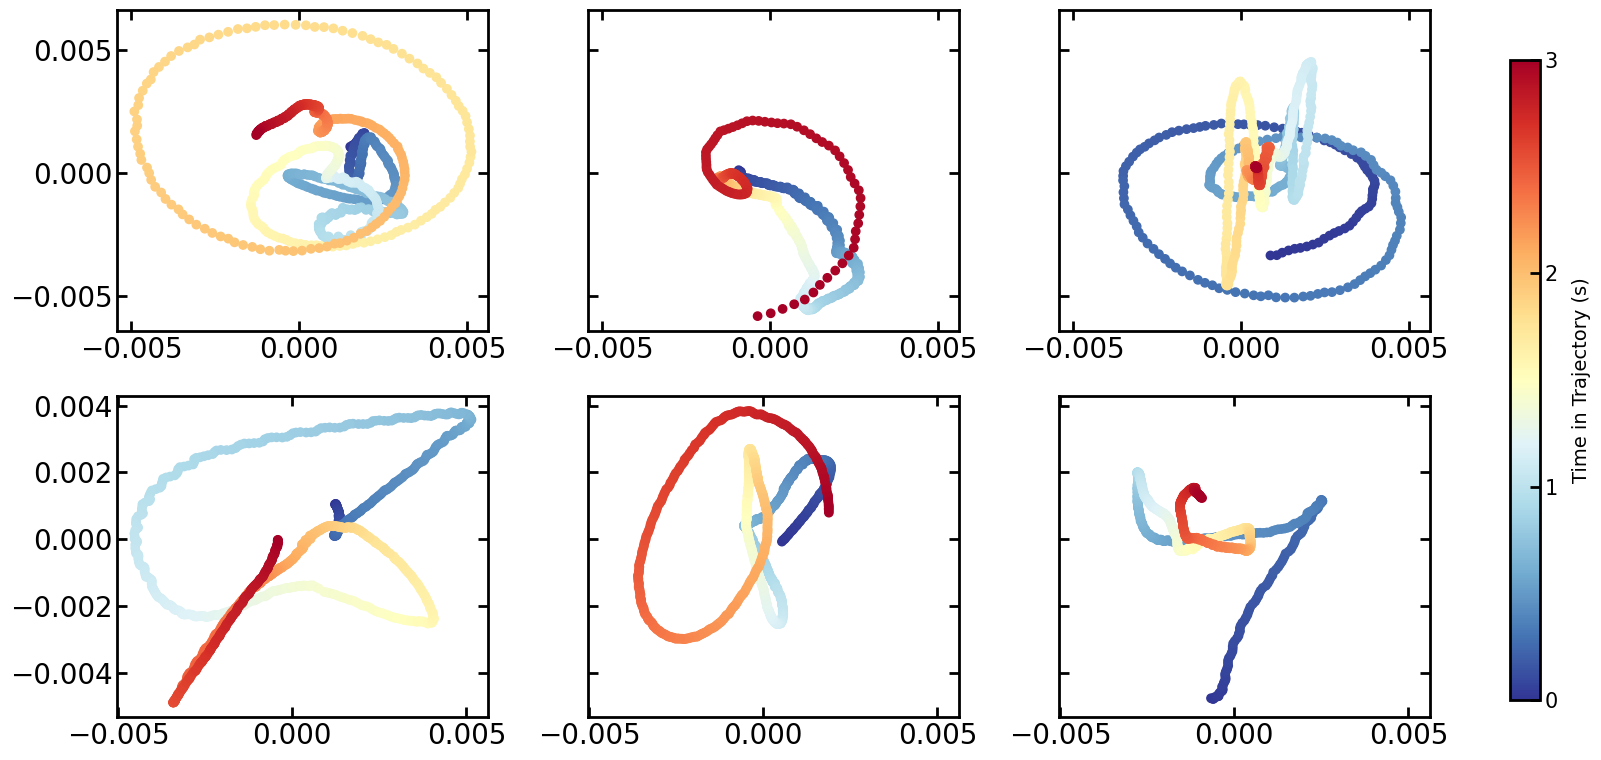

In [ ]:
response_length = 3 # s

cmap = plt.cm.get_cmap('RdYlBu_r')
color_list = cmap(np.linspace(0, 1, int(response_length/(dt*subsample))))

# fig = plt.figure(layout='constrained', figsize=(15, 8))
# subfigs = fig.subfigures(2, 1, wspace=0.07)

fig, axs = plt.subplots(2, 3, sharey='row', sharex='row', figsize=(15, 8))

for j, section in enumerate(['wake', 'anesthesia']):

    # axs = subfigs[num].subplots(1, 3, sharey='row')
    # axs = subfigs[num].subplots(1, 3)

    for i, trial_type in enumerate(np.unique(trial_info['cpt_trialType'])):
        ax = axs[j][i]
    
        ax.scatter(trial_emb_signals[section][trial_type][:, 0], trial_emb_signals[section][trial_type][:, 1], c=color_list)

        # for t in range(trial_emb_signals[section][trial_type].shape[0]):
        #     ellipse = Ellipse(xy=trial_emb_signals[section][trial_type][t, :2], width=trial_emb_signals_se[section][trial_type][t, 0], height=trial_emb_signals_se[section][trial_type][t, 1], 
        #                 edgecolor='none', fc=color_list[t], alpha=0.1)
        #     ax.add_patch(ellipse)
        # ax.set_title(f"{section} - {trial_type}")

    # subfigs[num].suptitle(section)
    # subfigs[t_num].tight_layout()

sm = plt.cm.ScalarMappable(cmap=cmap)
plt.tight_layout()
# fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1.02, 0.1, 0.02, 0.8])
cbar = fig.colorbar(sm, ticks=[0, 0.3333, 0.6666, 1], cax=cbar_ax)
cbar.ax.set_yticklabels([0, 1, 2, 3], fontsize=15)
cbar.set_label('Time in Trajectory (s)', fontsize=14)

plt.show()

# Align Each TRIAL EMBEDDED Trajectory to all others within a section/trial_type

In [53]:
response_length = 3 # s

trial_emb_signals = {}
trial_emb_signals_se = {}
for section in section_times.keys():
    trial_emb_signals[section] = {}
    trial_emb_signals_se[section] = {}
    for trial_type in np.unique(trial_info['cpt_trialType']):
        trial_emb_signals[section][trial_type] = None
        trial_emb_signals_se[section][trial_type] = None

for t in start_times:
    section = get_section(t, section_times)
    trial_indices = (trial_info['cpt_refTime'] >= t) & (trial_info['cpt_refTime'] < t + 30)
    ref_times = trial_info['cpt_refTime'][trial_indices]
    trial_types = trial_info['cpt_trialType'][trial_indices]

    for i, trial_type in enumerate(np.unique(trial_types)):
        trial_locs = np.int0((ref_times[trial_types == trial_type] - t)*(1/dt)/subsample)
        for loc in trial_locs:
            loc_emb_signal = all_embedded_signals[t][loc:loc + int(response_length/(dt*subsample))]
            if loc_emb_signal.shape[0] == int(response_length/(dt*subsample)):
                loc_emb_signal = np.expand_dims(loc_emb_signal, 0)
                if trial_emb_signals[section][trial_type] is None:
                    trial_emb_signals[section][trial_type] = loc_emb_signal
                else:
                    trial_emb_signals[section][trial_type] = np.concatenate([trial_emb_signals[section][trial_type], loc_emb_signal])

# COMPUTE MEANS AND SE
for section in trial_emb_signals.keys():
    for trial_type in trial_emb_signals[section].keys():
        if trial_emb_signals[section][trial_type] is not None:
            num_trials = trial_emb_signals[section][trial_type].shape[0]
            print(num_trials)
            standardized_signals = np.zeros(trial_emb_signals[section][trial_type].shape)
            for trial_num in range(1, num_trials):
                mtx1, mtx2, _ = scipy.spatial.procrustes(trial_emb_signals[section][trial_type][0], trial_emb_signals[section][trial_type][trial_num])
                
                # R, scale = scipy.linalg.orthogonal_procrustes(trial_emb_signals[section][trial_type][trial_num], trial_emb_signals[section][trial_type][0])
                # mtx1 = trial_emb_signals[section][trial_type][0]
                # mtx2 = trial_emb_signals[section][trial_type][trial_num] @ R
                
                if i == 1:
                    standardized_signals[0] = mtx1
                standardized_signals[trial_num] = mtx2

            trial_emb_signals[section][trial_type] = standardized_signals.mean(axis=0)
            trial_emb_signals_se[section][trial_type] = standardized_signals.std(axis=0) / np.sqrt(num_trials)

19
19
20
13
20
17
22
26
28
21
29
25
28
11
13


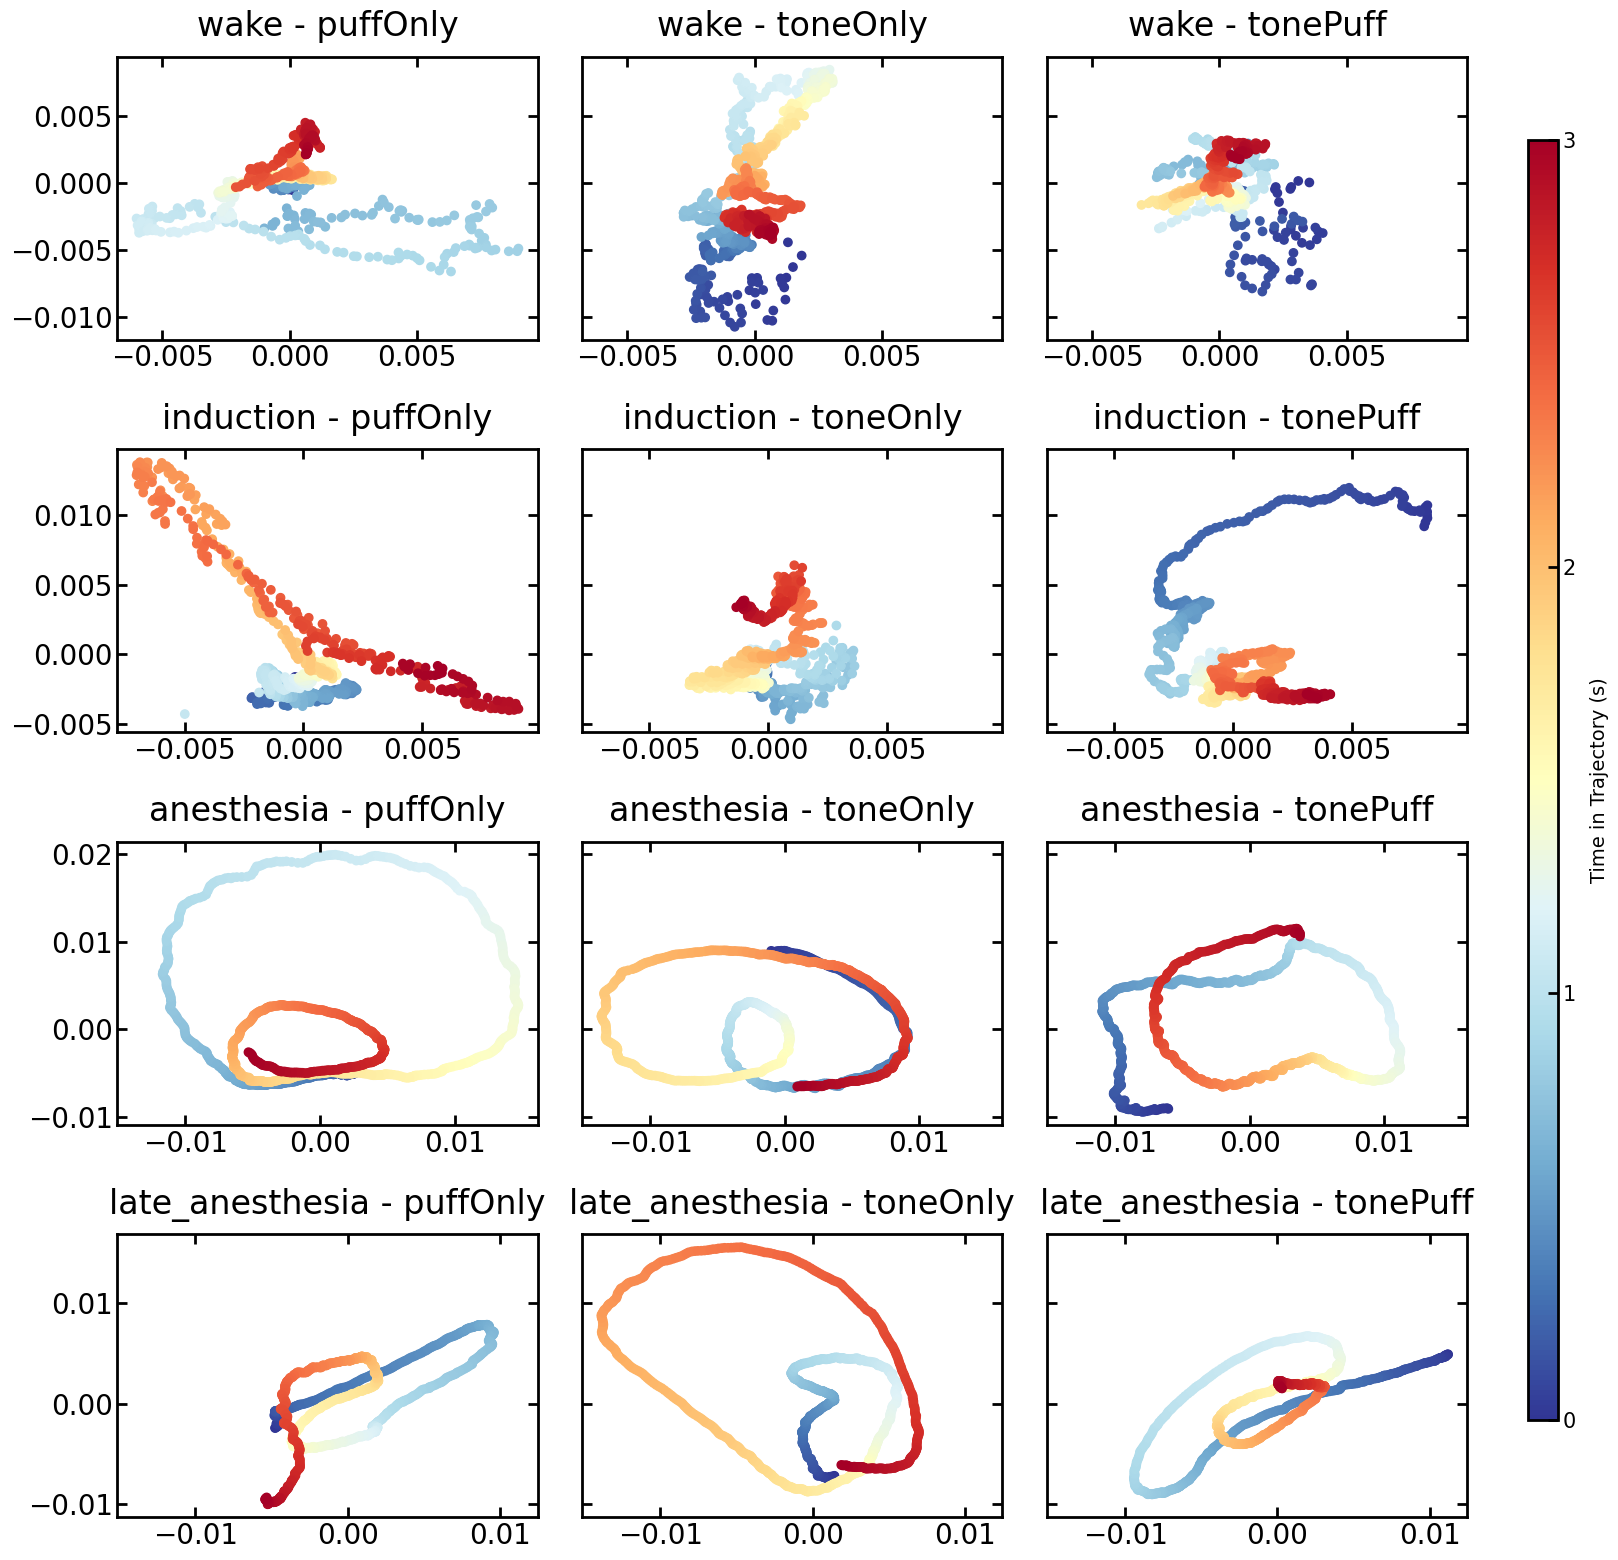

In [54]:
response_length = 3 # s

cmap = plt.cm.get_cmap('RdYlBu_r')
color_list = cmap(np.linspace(0, 1, int(response_length/(dt*subsample))))

# fig = plt.figure(layout='constrained', figsize=(15, 8))
# subfigs = fig.subfigures(2, 1, wspace=0.07)

# plot_sections = ['wake', 'anesthesia']
plot_sections = ['wake', 'induction', 'anesthesia', 'late_anesthesia']

fig, axs = plt.subplots(len(plot_sections), 3, sharey='row', sharex='row', figsize=(15, 4*len(plot_sections)))

for j, section in enumerate(plot_sections):

    # axs = subfigs[num].subplots(1, 3, sharey='row')
    # axs = subfigs[num].subplots(1, 3)

    for i, trial_type in enumerate(np.unique(trial_info['cpt_trialType'])):
        ax = axs[j][i]
    
        ax.scatter(trial_emb_signals[section][trial_type][:, 0], trial_emb_signals[section][trial_type][:, 1], c=color_list)

        # for t in range(trial_emb_signals[section][trial_type].shape[0]):
        #     ellipse = Ellipse(xy=trial_emb_signals[section][trial_type][t, :2], width=trial_emb_signals_se[section][trial_type][t, 0], height=trial_emb_signals_se[section][trial_type][t, 1], 
        #                 edgecolor='none', fc=color_list[t], alpha=0.1)
        #     ax.add_patch(ellipse)

        ax.set_title(f"{section} - {trial_type}")

    # subfigs[num].suptitle(section)
    # subfigs[t_num].tight_layout()

sm = plt.cm.ScalarMappable(cmap=cmap)
plt.tight_layout()
# fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1.02, 0.1, 0.02, 0.8])
cbar = fig.colorbar(sm, ticks=[0, 0.3333, 0.6666, 1], cax=cbar_ax)
cbar.ax.set_yticklabels([0, 1, 2, 3], fontsize=15)
cbar.set_label('Time in Trajectory (s)', fontsize=14)

plt.show()

## 3D plot

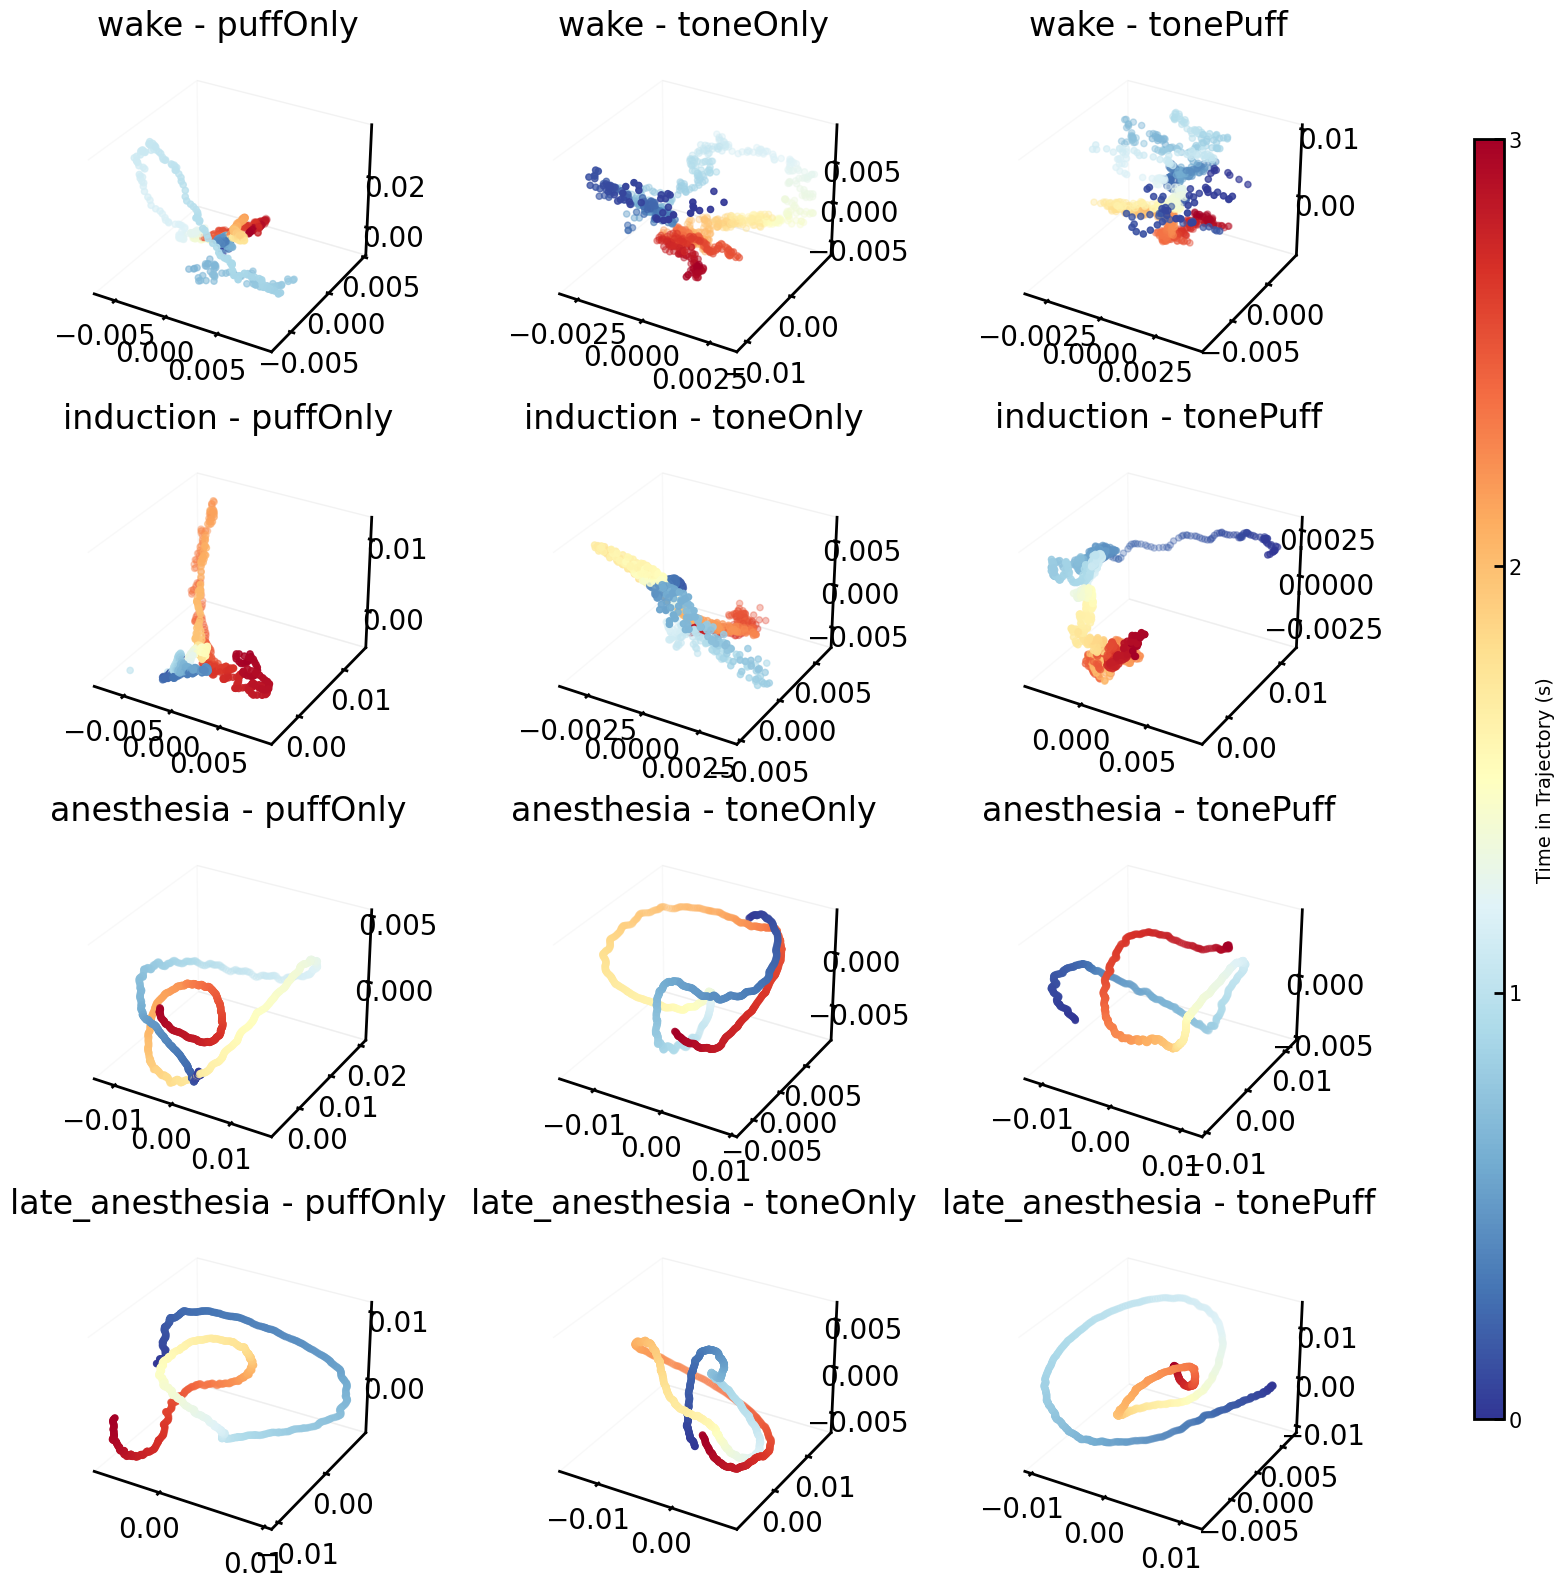

In [55]:
response_length = 3 # s

cmap = plt.cm.get_cmap('RdYlBu_r')
color_list = cmap(np.linspace(0, 1, int(response_length/(dt*subsample))))

# fig = plt.figure(layout='constrained', figsize=(15, 8))
# subfigs = fig.subfigures(2, 1, wspace=0.07)

# plot_sections = ['wake', 'anesthesia']
plot_sections = ['wake', 'induction', 'anesthesia', 'late_anesthesia']

fig, axs = plt.subplots(len(plot_sections), 3, sharey='row', sharex='row', figsize=(15, 4*len(plot_sections)))

for j, section in enumerate(plot_sections):

    # axs = subfigs[num].subplots(1, 3, sharey='row')
    # axs = subfigs[num].subplots(1, 3)

    for i, trial_type in enumerate(np.unique(trial_info['cpt_trialType'])):
        ax = axs[j][i]
        ax.remove()
        ax = fig.add_subplot(len(plot_sections), 3, j*3 + i + 1, projection='3d')
        ax.scatter(trial_emb_signals[section][trial_type][:, 0], trial_emb_signals[section][trial_type][:, 1], trial_emb_signals[section][trial_type][:, 2], c=color_list)
        ax.grid(False)
        ax.w_xaxis.pane.fill = False
        ax.w_yaxis.pane.fill = False
        ax.w_zaxis.pane.fill = False

        # for t in range(trial_emb_signals[section][trial_type].shape[0]):
        #     ellipse = Ellipse(xy=trial_emb_signals[section][trial_type][t, :2], width=trial_emb_signals_se[section][trial_type][t, 0], height=trial_emb_signals_se[section][trial_type][t, 1], 
        #                 edgecolor='none', fc=color_list[t], alpha=0.1)
        #     ax.add_patch(ellipse)

        ax.set_title(f"{section} - {trial_type}")

    # subfigs[num].suptitle(section)
    # subfigs[t_num].tight_layout()

sm = plt.cm.ScalarMappable(cmap=cmap)
plt.tight_layout()
# fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1.02, 0.1, 0.02, 0.8])
cbar = fig.colorbar(sm, ticks=[0, 0.3333, 0.6666, 1], cax=cbar_ax)
cbar.ax.set_yticklabels([0, 1, 2, 3], fontsize=15)
cbar.set_label('Time in Trajectory (s)', fontsize=14)

plt.show()

# Plotting Individual Trials

In [ ]:
response_length = 3 # s

trial_emb_signals = {}
trial_emb_signals_se = {}
for section in section_times.keys():
    trial_emb_signals[section] = {}
    trial_emb_signals_se[section] = {}
    for trial_type in np.unique(trial_info['cpt_trialType']):
        trial_emb_signals[section][trial_type] = None
        trial_emb_signals_se[section][trial_type] = None

for t in start_times:
    section = get_section(t, section_times)
    trial_indices = (trial_info['cpt_refTime'] >= t) & (trial_info['cpt_refTime'] < t + 30)
    ref_times = trial_info['cpt_refTime'][trial_indices]
    trial_types = trial_info['cpt_trialType'][trial_indices]

    for i, trial_type in enumerate(np.unique(trial_types)):
        trial_locs = np.int0((ref_times[trial_types == trial_type] - t)*(1/dt)/subsample)
        for loc in trial_locs:
            loc_emb_signal = all_embedded_signals[t][loc:loc + int(response_length/(dt*subsample))]
            if loc_emb_signal.shape[0] == int(response_length/(dt*subsample)):
                loc_emb_signal = np.expand_dims(loc_emb_signal, 0)
                if trial_emb_signals[section][trial_type] is None:
                    trial_emb_signals[section][trial_type] = loc_emb_signal
                else:
                    trial_emb_signals[section][trial_type] = np.concatenate([trial_emb_signals[section][trial_type], loc_emb_signal])

# ALIGN
for section in trial_emb_signals.keys():
    for trial_type in trial_emb_signals[section].keys():
        if trial_emb_signals[section][trial_type] is not None:
            num_trials = trial_emb_signals[section][trial_type].shape[0]

            standardized_signals = np.zeros(trial_emb_signals[section][trial_type].shape)
            for trial_num in range(1, num_trials):
                mtx1, mtx2, _ = scipy.spatial.procrustes(trial_emb_signals[section][trial_type][0], trial_emb_signals[section][trial_type][trial_num])
                
                # R, scale = scipy.linalg.orthogonal_procrustes(trial_emb_signals[section][trial_type][trial_num], trial_emb_signals[section][trial_type][0])
                # mtx1 = trial_emb_signals[section][trial_type][0]
                # mtx2 = trial_emb_signals[section][trial_type][trial_num] @ R
                
                if i == 1:
                    standardized_signals[0] = mtx1
                standardized_signals[trial_num] = mtx2

            trial_emb_signals[section][trial_type] = standardized_signals

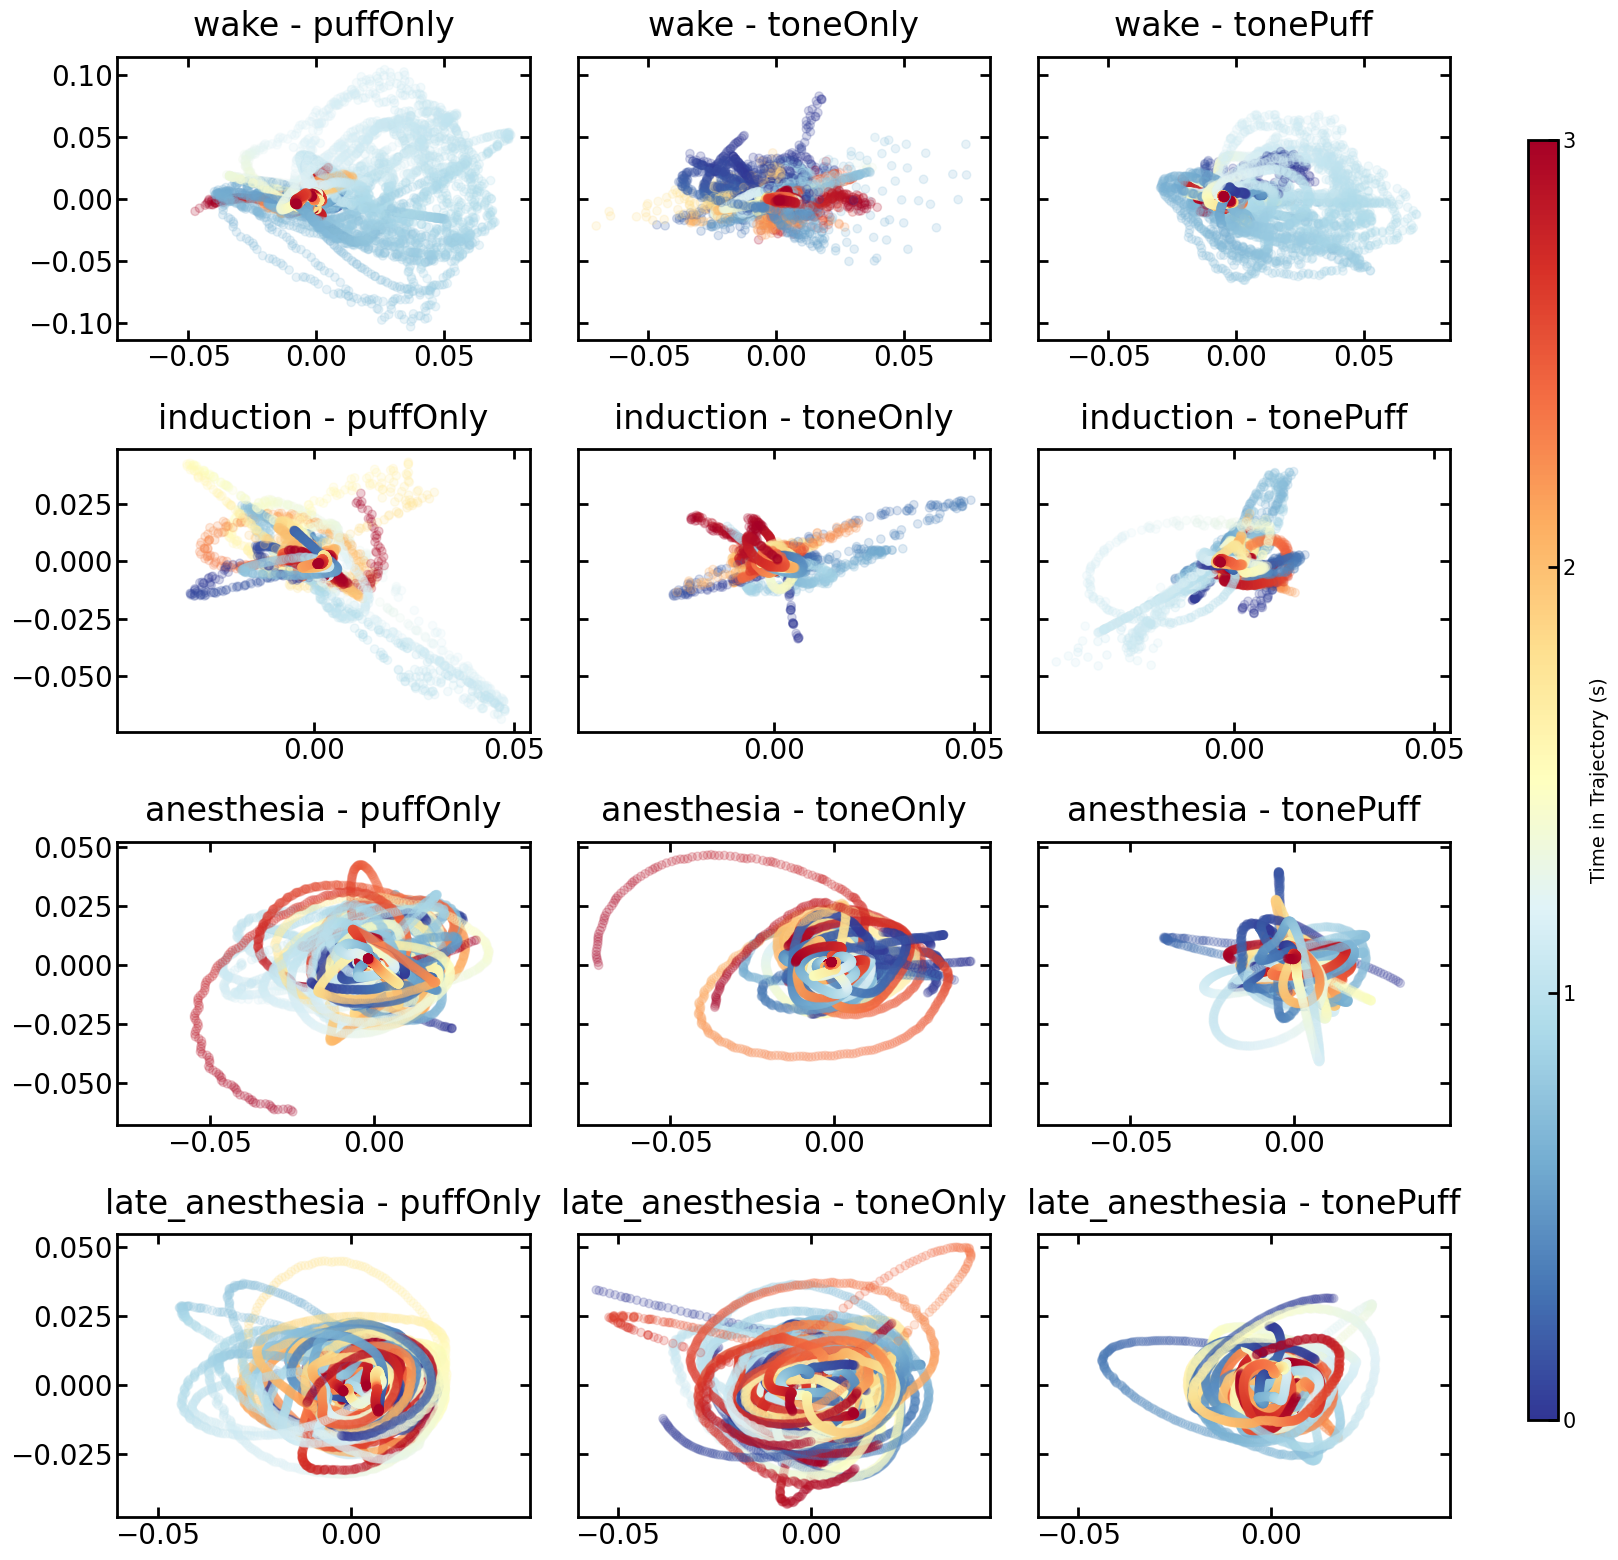

In [ ]:
response_length = 3 # s

cmap = plt.cm.get_cmap('RdYlBu_r')
color_list = cmap(np.linspace(0, 1, int(response_length/(dt*subsample))))

# fig = plt.figure(layout='constrained', figsize=(15, 8))
# subfigs = fig.subfigures(2, 1, wspace=0.07)

# plot_sections = ['wake', 'anesthesia']
plot_sections = ['wake', 'induction', 'anesthesia', 'late_anesthesia']

fig, axs = plt.subplots(len(plot_sections), 3, sharey='row', sharex='row', figsize=(15, 4*len(plot_sections)))

for j, section in enumerate(plot_sections):

    # axs = subfigs[num].subplots(1, 3, sharey='row')
    # axs = subfigs[num].subplots(1, 3)

    for i, trial_type in enumerate(np.unique(trial_info['cpt_trialType'])):
        ax = axs[j][i]

        for trial_num in range(trial_emb_signals[section][trial_type].shape[0]):
            ax.scatter(trial_emb_signals[section][trial_type][trial_num, :, 0], trial_emb_signals[section][trial_type][trial_num, :, 1], c=color_list, alpha=0.2)

        # for t in range(trial_emb_signals[section][trial_type].shape[0]):
        #     ellipse = Ellipse(xy=trial_emb_signals[section][trial_type][t, :2], width=trial_emb_signals_se[section][trial_type][t, 0], height=trial_emb_signals_se[section][trial_type][t, 1], 
        #                 edgecolor='none', fc=color_list[t], alpha=0.1)
        #     ax.add_patch(ellipse)

        ax.set_title(f"{section} - {trial_type}")

    # subfigs[num].suptitle(section)
    # subfigs[t_num].tight_layout()

sm = plt.cm.ScalarMappable(cmap=cmap)
plt.tight_layout()
# fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1.02, 0.1, 0.02, 0.8])
cbar = fig.colorbar(sm, ticks=[0, 0.3333, 0.6666, 1], cax=cbar_ax)
cbar.ax.set_yticklabels([0, 1, 2, 3], fontsize=15)
cbar.set_label('Time in Trajectory (s)', fontsize=14)

plt.show()